In [15]:
def fitNN(Xd, yd, modelNN, frac_tr = 0.8, shuffle = False, N_epochs = 10, val_frac = 0., cut_train = 0):
    
    ltrain, ltest, loss_train, loss_test = [], [], [], []
   
    #fix the length of total set: cut_train >0 reduces the length of total set
    length = len(ydata) 
    if cut_train!=0:
        length = int(length * cut_train)
    
    #cycle over the whole set of length "length" (from 4: there are some problems with keras' "fit")
    for m1 in range(4,length):
        print("#"*int(100 * m1 / length), "{0:.0f}%".format(100 * m1 / length), end='\r')
        m1_train = int(m1 * frac_tr)
        
        #shuffle or not the set
        if shuffle:
            Xnp_train, Xnp_test, ynp_train, ynp_test = train_test_split(Xdata, ydata, test_size=m1 - m1_train,\
            train_size=m1_train)
        else:
            Xnp_train, Xnp_test, ynp_train, ynp_test = Xdata[:m1_train], Xdata[m1_train:], ydata[:m1_train], ydata[m1_train:] 
        
        #fit
        model.fit(Xnp_train , ynp_train , epochs= N_epochs , verbose = 0 , shuffle = True , validation_split = val_frac)
        
        #score evaluation of training set
        score = model.evaluate(Xnp_train , ynp_train , verbose = 0)
        loss_train.append(score[0])
        ltrain.append(score[1])
        
        #score evaluation of test set
        score = model.evaluate(Xnp_test , ynp_test , verbose = 0)
        loss_test.append(score[0])
        ltest.append(score[1])
    
    return ltrain, ltest, loss_train, loss_test

def filtering(lst, n0 = 3):
    arr = np.zeros(len(lst))
    for i in range(len(lst)):
        arr[i] = lst[i]
    arr = arr[:(len(arr) // n0) * n0]
    return np.mean(arr.reshape(-1, n0) , axis = 1)

In [3]:
import pandas as pd
## input
df = pd.read_csv("C:\\Users\\unieuro\\Documents\\ML\\WondrousMachineLaundry-master\\titanic\\data\\train.csv")

## mapping strings to numbers
df["Sex"] = df["Sex"].replace({"male":0, "female":1})
df["Embarked"] = df["Embarked"].replace({'C':0, 'S':1, 'Q':2})

## handling names
title_dict = {"Mr.":0, "Mrs.":1, "Mme.":1, "Miss.":2, "Mlle.":2, "Master.":3, "Dr.":4, "Rev.": 5}
for i_row, row in df.iterrows():
    name_str = row["Name"]
    if not isinstance(name_str, str):
        break # break the loop if the names have already been replaced by ints
    df.loc[i_row,"Name"] = 6 # assign the default value at the begining
    for word in name_str.split():
        if word in title_dict.keys():
            df.loc[i_row,"Name"] = title_dict[word]
            break # break the loop if the key value has been found
        
## handling nans
df = df.drop(columns=["Cabin"])
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode().iloc[0])

## get dummies
features = ["Pclass", "Name"]
for f in features:
    df = pd.concat([df.drop(columns=f), pd.get_dummies(df[f], prefix=f)], axis=1)

## creating input and output dataframes
yf = df["Survived"]
Xf = df.drop(columns=["PassengerId", "Survived", "Ticket"])

## normalizing
features = ["Age", "Fare"]
Xf[features] = (Xf[features] - Xf[features].mean()) / Xf[features].std()
print(Xf.head())

   Sex       Age  SibSp  Parch      Fare  Embarked  Pclass_1  Pclass_2  \
0    0 -0.565419      1      0 -0.502163       1.0         0         0   
1    1  0.663488      1      0  0.786404       0.0         1         0   
2    1 -0.258192      0      0 -0.488580       1.0         0         0   
3    1  0.433068      1      0  0.420494       1.0         1         0   
4    0  0.433068      0      0 -0.486064       1.0         0         0   

   Pclass_3  Name_0  Name_1  Name_2  Name_3  Name_4  Name_5  Name_6  
0         1       1       0       0       0       0       0       0  
1         0       0       1       0       0       0       0       0  
2         1       0       0       1       0       0       0       0  
3         0       0       1       0       0       0       0       0  
4         1       1       0       0       0       0       0       0  


In [4]:
Xdata=Xf.loc[:,:].to_numpy()
ydata=yf.loc[:].to_numpy()

In [18]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation

lst_train, lst_test, lst_loss_train, lst_loss_test = [], [], [], []

model = Sequential()
model.add(Dense(10, input_dim = Xdata.shape[1], activation='relu'))#somehow, relu is working much better than sigmoid
model.add(Dense(10, activation='relu'))
#model.add(Dense(5, activation='relu'))
#model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy' , optimizer='rmsprop' , metrics=['accuracy'])

lst_train, lst_test, lst_loss_train, lst_loss_test = fitNN(Xd = Xdata, yd = ydata, modelNN = model,\
N_epochs = 10, shuffle = True, cut_train = 0.9) #default frac_train=0.8

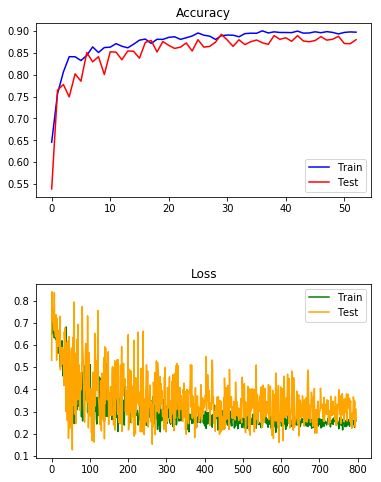

In [19]:
from matplotlib import pyplot as plt
import numpy as np

n0 = 15

fig,axs = plt.subplots(2, figsize=(6,8))
fig.subplots_adjust(hspace=.5)

axs[0].plot(filtering(lst_train, n0), color = 'blue', label = "Train")
axs[0].plot(filtering(lst_test, n0), color= 'red', label = "Test")
axs[0].set_title("Accuracy")
axs[0].legend()

axs[1].plot(range(len(lst_train)), lst_loss_train, color = 'green', label = "Train")
axs[1].plot(range(len(lst_test)), lst_loss_test, color= 'orange', label = "Test")
axs[1].set_title("Loss")
axs[1].legend()

plt.show()